# Lunar Data

First we will download the data using the kaggle api

In [ ]:
!kaggle datasets download -p data romainpessia/artificial-lunar-rocky-landscape-dataset`

Then we can unzip:

In [ ]:
!unzip -d data/lunar data/artificial-lunar-rocky-landscape-dataset.zip

Now lets try to explore the data. First do our imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Don't know if i need all of these yet, but based on `lesson3-camvid.ipynb`, and `lesson3-camvid-tiramisu.ipynb`.

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Unzip the rest

In [33]:
!chmod u+rw -R data/lunar
!unzip -d data/lunar/images data/lunar/images.zip

Archive:  data/lunar/images.zip
replace data/lunar/images/new/ground/ground2020.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
!unzip -q -d data/lunar/real_moon_images data/lunar/real_moon_images.zip

Load them into data bunches

In [34]:
art_path = Path("data/lunar/images/new/")
ground_paths = get_image_files(art_path/"ground")
render_paths = get_image_files(art_path/"render")

img_path = Path("data/lunar/real_moon_images/")
moon_paths = get_image_files(img_path)

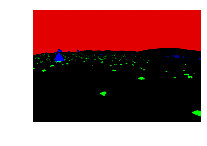

In [35]:
ground_img = open_image(ground_paths[0])
ground_img.show()

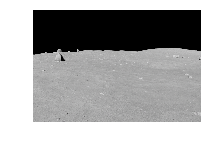

In [40]:
def get_render(ground_path): 
    render_name = "render" + ground_path.name[6:]
    render_dir = ground_path.parent.parent/"render"
    return Path(render_dir/Path(render_name))

render_img = open_image(get_render(ground_names[0]))
render_img.show()

In [42]:
doc(SegmentationItemList)

class SegmentationItemList [source] SegmentationItemList ( * args , convert_mode = 'RGB' , ** kwargs ) :: ImageList 
 
 ItemList suitable for segmentation tasks. 
 Show in docs